In [1]:
# Импорт библиотек
import os
import time

import ASW
import GTU
import KU_TU
import mat_properties as prop
import numpy as n
import pandas as pd
import SP
from scipy.optimize import root

# таблица номинального режима
gas_streams0 = pd.read_excel("streams0.xlsx", sheet_name="gas", index_col=0)
water_streams0 = pd.read_excel("streams0.xlsx", sheet_name="water", index_col=0)
GTU_ISO = pd.read_excel("input.xlsx", sheet_name="ISO", index_col=0)
GTU_input = pd.read_excel("input.xlsx", sheet_name="GTU_input", index_col=0)
# рабочая таблица (=номинал в 1 итерации)
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
water_streams = pd.read_excel("streams.xlsx", sheet_name="water", index_col=0)
# рабочая таблица показателей блоков
heaters = pd.read_excel("blocks.xlsx", sheet_name="heaters", index_col=0)
electric = pd.read_excel("blocks.xlsx", sheet_name="electric", index_col=0)
accumulation = pd.read_excel("blocks.xlsx", sheet_name="accumulation", index_col=0)
# Состав газов в номинале
gasmix = "Nitrogen*Oxygen*CO2*Water*Argon"
# Считывание рефпропа
RP = prop.init_REFPROP(r"C:\Program Files (x86)\REFPROP")
fractiongas0 = (
    gas_streams0.at["GTU-PEVD", "N2"],
    gas_streams0.at["GTU-PEVD", "O2"],
    gas_streams0.at["GTU-PEVD", "CO2"],
    gas_streams0.at["GTU-PEVD", "H2O"],
    gas_streams0.at["GTU-PEVD", "Ar"],
)

gas0 = prop.Materials_prop(
    gasmix,
    fractiongas0,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)
water = prop.Materials_prop(
    "water",
    [1.0, 0, 0, 0, 0],
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Задание энтальпий газа в номинальном режиме
Temperatures = gas_streams0.loc["GTU-KU":"GPK-out", "T"]
Pressure = gas_streams0.loc["GTU-KU", "P"]
Enthalpies = list(map(lambda x: gas0.p_t(Pressure, x)["h"], Temperatures))
gas_streams0.loc["GTU-KU":"GPK-out", "H"] = Enthalpies


# Состав газов при частичной нагрузке
fractiongas = (
    gas_streams.at["GTU-PEVD", "N2"],
    gas_streams.at["GTU-PEVD", "O2"],
    gas_streams.at["GTU-PEVD", "CO2"],
    gas_streams.at["GTU-PEVD", "H2O"],
    gas_streams.at["GTU-PEVD", "Ar"],
)
gas1 = prop.Materials_prop(
    gasmix,
    fractiongas,
    prop.REFPROP_h_s,
    prop.REFPROP_p_t,
    prop.REFPROP_p_h,
    prop.REFPROP_p_s,
    prop.REFPROP_p_q,
    prop.REFPROP_t_q,
    prop.REFPROP_p_rho,
    prop.REFPROP_s_q,
    RP=RP,
)

# Основные константы
Calcmethod = "hybr"
KPD_PN = 0.8074
KPD_KN = 0.75
KPD_to = 0.99
KPD_SP = 0.99

Calctolerance = 10**-2
Teplo = 1
Maxiterations_KU_TU = 10
Maxiterations_cotel = 4
Maxiterations_turbine = 30
steamVD_fraction_to_turbine = 1
steamVD_to_turbine = 0

# --------------------------------- ВАРЬИРУЕМЫЕ ПАРАМЕТРЫ
# Задаем нагрузку
GTU_input.at["n", 1] = 1
GTU_input.at["tair", 1] = 7
vremya = 4
# # Выбор происходит ли зарядка : 1 - заряжается, 2 - разряжается, любое другое число - не участвует в расчете
ASWbul = 1
# ----------------------------------------------------------
# print(GTU_input)
############################################################
# Теплосеть
gas_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
water_streams.loc["AIR", "T":"P"] = [GTU_input.loc["tair", 1], 0.1]
Tnv = gas_streams.at["AIR", "T"]
water_streams.at["SWIN-TURB", "T"] = SP.Tset(Tnv)[1]
water_streams.at["SP2-WOUT", "T"] = SP.Tset(Tnv)[0]

water_streams.at["SWOUT", "T"] = SP.Tset(Tnv)[0]
water_streams.at["SWIN", "T"] = SP.Tset(Tnv)[1]
# print(water_streams)
############################################################
# --------------------------------Расчет ГТУ
Gas_turbine = GTU.gtu(GTU_ISO, "GTU-KU")
Gas_turbine_res = Gas_turbine.calc(GTU_input)
electric.at["GTU", "N"] = Gas_turbine_res["N"]
electric.at["GTU", "KPD"] = Gas_turbine_res["eff"]
electric.at["DK", "N"] = Gas_turbine_res["Ndk"]
gas_streams = pd.read_excel("streams.xlsx", sheet_name="gas", index_col=0)
gas_streams.at["GTU-KU", "T"] = Gas_turbine_res["T"]
gas_streams.at["GTU-KU", "G"] = Gas_turbine_res["G"]
gas_streams.at["GTU-KU", "P"] = 0.1
gas_streams.at["GTU-KU", "H"] = gas0.p_t(
    gas_streams.at["GTU-KU", "P"], gas_streams.at["GTU-KU", "T"]
)["h"]
Gas_turbine_composition = pd.read_excel(
    "input.xlsx", sheet_name="Gas_composition0", index_col=0
)

# Параметры газа на выходе в КУ
gas_streams.loc["GTU-PEVD", "T":"P"] = gas_streams.loc["GTU-KU", "T":"P"]
gas_streams.at["GTU-PEVD", "G"] = gas_streams.loc["GTU-KU", "G"]
gas_streams.loc["GTU-PEVD", "N2":"Ar"] = Gas_turbine_composition.loc[
    "Fraction", "N2":"Ar"
]
# --------------------------------------------------------------------------
# Class KU+TU
KU_and_TU = KU_TU.ku_tu(
    gas0,
    gas1,
    water,
    gas_streams0,
    gas_streams,
    water_streams0,
    water_streams,
    heaters,
    electric,
    "PEVD-DROSVD",
    "PPND-DROSND",
    "DROSVD-TURBVD",
    "DROSND-TURBND",
    Calcmethod,
    KPD_SP,
    KPD_KN,
    KPD_to,
    KPD_PN,
    steamVD_fraction_to_turbine,
    steamVD_to_turbine,
)

ASW = ASW.Accum(
    water,
    water_streams,
    accumulation,
    stream12="ASW-WOUT",
    stream11="SP2-ASW",
    stream_obratnoi_setevoi_vody="SWIN-TURB",
    stream_pryamoi_setevoi_vody="SP2-WOUT",
    T_nar_vozd=water_streams.at["AIR", "T"],
)

ASW.set_construct(
    Diametr=10, kolichestvo=2, Visota=5, lambda_min_vata=0.045, delta_min_vata=0.01
)

start_time = time.time()

# # если Зарядка
if ASWbul == 1:
    G_ASW_zarydka = ASW.zaryadka(vremya)["G"]
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] + G_ASW_zarydka
    # если разрядка
if ASWbul == 2:
    ASW.zaryadka(vremya)
    ASW.jdat(12)
    G_ASW_razryadka = ASW.razryadka(vremya)["G"]
    water_streams.at["SWIN-TURB", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SP2-WOUT", "G"] = water_streams.at["SWIN", "G"] - G_ASW_razryadka
    water_streams.at["SWOUT", "H"] = water.p_t(
        water_streams.at["SWOUT", "P"], water_streams.at["SWOUT", "T"]
    )["h"]
    water_streams.at["SP2-WOUT", "H"] = (
        water_streams.at["SWOUT", "H"] * water_streams.at["SWOUT", "G"]
        - water_streams.at["ASW-WOUT", "H"] * G_ASW_razryadka
    ) / (water_streams.at["SWOUT", "G"] - G_ASW_razryadka)
    water_streams.at["SP2-WOUT", "T"] = water.p_h(
        water_streams.at["SP2-WOUT", "P"], water_streams.at["SP2-WOUT", "H"]
    )["T"]

KU_and_TU.calculate(
    Teplo,
    Calctolerance,
    Maxiterations_KU_TU,
    Maxiterations_cotel,
    Maxiterations_turbine,
)

print(
    "Степень сухости пара в ЭВД: ",
    water.p_h(water_streams.at["EVD-IVD", "P"], water_streams.at["EVD-IVD", "H"])["Q"],
)
print(
    "Степень сухости пара в ГПК: ",
    water.p_h(water_streams.at["GPK-IND", "P"], water_streams.at["GPK-IND", "H"])["Q"],
)

print(f"fin КУ и ТУ:--- {round((time.time() - start_time), 1)} сек. ---")
electric

Относительная мощность ГТУ в ГТУ 1
168933699.38447797
Достигнуто максимальное количество итераций контура высокого давления
Достигнуто максимальное количество итераций контура низкого давления
Достигнуто максимальное количество итераций контура низкого давления
Повышена точность расчета котла для увеличения сходимости
dQ/Q ПЕВД+ИВД+ЭВД 2.5654862081790806
dQ/Q ПЕВД+ИВД+ЭВД -1.4687667224243253
dQ/Q ПЕВД+ИВД+ЭВД 0.7137432439490226
dQ/Q ПЕВД+ИВД+ЭВД -0.3524432016022294
dQ/Q ПЕВД+ИВД+ЭВД 0.17353758238507988
Достигнуто максимальное количество итераций контура высокого давления
dQ/Q ППНД+ИНД+ГПК 0.41906068456177115
dQ/Q ППНД+ИНД+ГПК -0.0687730139731089
Fin котел-утилизатора:--- 26.73 сек. ---
dQ/Qsumm 0.074137248817404
Fin турбоустановка:--- 0.08 сек. ---
Fin котел-утилизатора:--- 7.15 сек. ---
dQ/Qsumm 0.0031181552231150955
Fin турбоустановка:--- 0.07 сек. ---
Fin котел-утилизатора:--- 2.52 сек. ---
dQ/Qsumm 0.0014718780984329766
Fin турбоустановка:--- 0.06 сек. ---
Fin котел-утилизатора:---

,Ni,N,KPDm,KPD
PEN,0.696159,0.713265,0.976017,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.574074,NaN,NaN,NaN
Tots1,37.391362,NaN,NaN,0.848272
Tots2,15.038837,NaN,NaN,0.682379
Tots3,5.152844,NaN,NaN,0.671686
Tots4,-0.008968,NaN,NaN,-0.033063


In [2]:
result = {
    "GTU": round(electric.at["GTU", "N"], 4),
    "GTU_KPD": round(electric.at["GTU", "KPD"], 4),
    "Turbine": round(electric.at["Turbine", "Ni"], 4),
    "KN": round(electric.at["KN", "Ni"], 4),
    "DK": round(electric.at["DK", "N"], 4),
    "PEN": round(electric.at["PEN", "Ni"], 4),
    "Turbine_Qt":round(heaters.at["SP2", "Qw"]+heaters.at["SP1", "Qw"]+heaters.at["OD", "Qw"], 4),
    "ASW_Qt":round(accumulation.at["ASW", "Qw"]/(vremya*3600), 4)
    }
result

{'GTU': 157.9794,
 'GTU_KPD': 33.7458,
 'Turbine': 57.5741,
 'KN': 0.0272,
 'DK': 6.2851,
 'PEN': 0.6962,
 'Turbine_Qt': 178.8059,
 'ASW_Qt': 11.7315}

In [3]:
water_streams

,T,P,H,G,S,X
AIR,7.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.076370,8.369434,3415.151784,63.298122,NaN,NaN
IVD-PEVD,300.993956,8.708810,2747.704151,63.298122,NaN,NaN
EVD-IVD,298.988173,8.708810,1339.065217,63.298122,NaN,NaN
PEN-EVD,163.565332,8.708810,695.614994,63.298122,NaN,NaN
BND-PEN,162.102969,0.652014,684.616903,63.298122,NaN,NaN
PPND-DROSND,207.545985,0.646024,2864.789361,15.027997,NaN,NaN
IND-PPND,162.102969,0.652014,2759.731806,15.027997,NaN,NaN
GPK-IND,158.718822,0.652014,669.941464,78.326119,NaN,NaN
GPK-REC,158.718822,0.652014,669.941464,92.314722,NaN,NaN


In [4]:
electric

,Ni,N,KPDm,KPD
PEN,0.696159,0.713265,0.976017,0.807400
CVD,NaN,NaN,NaN,NaN
CND,NaN,NaN,NaN,NaN
GTU,NaN,157.979400,NaN,33.745787
DK,NaN,6.285084,NaN,NaN
Turbine,57.574074,NaN,NaN,NaN
Tots1,37.391362,NaN,NaN,0.848272
Tots2,15.038837,NaN,NaN,0.682379
Tots3,5.152844,NaN,NaN,0.671686
Tots4,-0.008968,NaN,NaN,-0.033063


In [5]:
heaters

,Qw,Qg,KPD
PEVD,42245.501583,42672.223821,0.99
IVD,89163.459912,90064.100921,0.99
EVD,40729.130337,41140.535694,0.99
PPND,1578.798478,1594.745937,0.99
IND,32333.491100,32660.092020,0.99
GPK,38608.817073,38998.805124,0.99
SP2,86.010183,NaN,0.99
SP1,85.190762,NaN,0.99
OD,7.604924,NaN,0.99
NaN,NaN,NaN,NaN


In [6]:
accumulation

,Qw,T
ASW,168933.699384,90.0


In [7]:
Errors_water = abs(water_streams - water_streams0) / water_streams0 * 100
Errors_gas = abs(gas_streams - gas_streams0) / gas_streams0 * 100
Errors_gas
Errors_water

,G,H,P,S,T,X
AIR,NaN,NaN,NaN,NaN,53.333333,NaN
ASW-OD,NaN,NaN,NaN,NaN,NaN,NaN
ASW-WOUT,NaN,NaN,NaN,NaN,NaN,NaN
BND-PEN,0.160690,1.649007,6.373682,NaN,1.599744,NaN
DOOTB1,49.716434,5.389769,80.909491,4.699883,NaN,NaN
DOOTB2,0.212537,3.107977,59.764970,2.685011,23.716414,NaN
DROSND-TURBND,1.815698,0.231160,8.685725,0.384036,2.036157,NaN
DROSVD-ST,NaN,NaN,NaN,NaN,NaN,NaN
DROSVD-TURBVD,0.160690,0.215446,0.447556,NaN,0.622452,NaN
ENDOFVD,0.160690,0.697950,10.080453,NaN,5.387557,NaN


In [8]:
GTU_input

,1,2,3,4,5,6
tair,7,NaN,NaN,NaN,NaN,NaN
n,1,NaN,NaN,NaN,NaN,NaN
Pin,0,NaN,NaN,NaN,NaN,NaN
Pout,0,NaN,NaN,NaN,NaN,NaN


,T,P,H,G,S,X
AIR,7.000000,0.100000,NaN,NaN,NaN,NaN
PEVD-DROSVD,508.076370,8.369434,3415.151784,63.298122,6.727228,NaN
IVD-PEVD,300.993956,8.708810,2747.704151,63.298122,NaN,NaN
EVD-IVD,298.988173,8.708810,1339.065217,63.298122,NaN,NaN
PEN-EVD,163.565332,8.708810,695.614994,63.298122,NaN,NaN
BND-PEN,162.102969,0.652014,684.616903,63.298122,NaN,NaN
PPND-DROSND,207.545985,0.646024,2864.789361,15.027997,6.965047,NaN
IND-PPND,162.102969,0.652014,2759.731806,15.027997,NaN,NaN
GPK-IND,158.718822,0.652014,669.941464,78.326119,NaN,NaN
GPK-REC,158.718822,0.652014,669.941464,92.314722,NaN,NaN


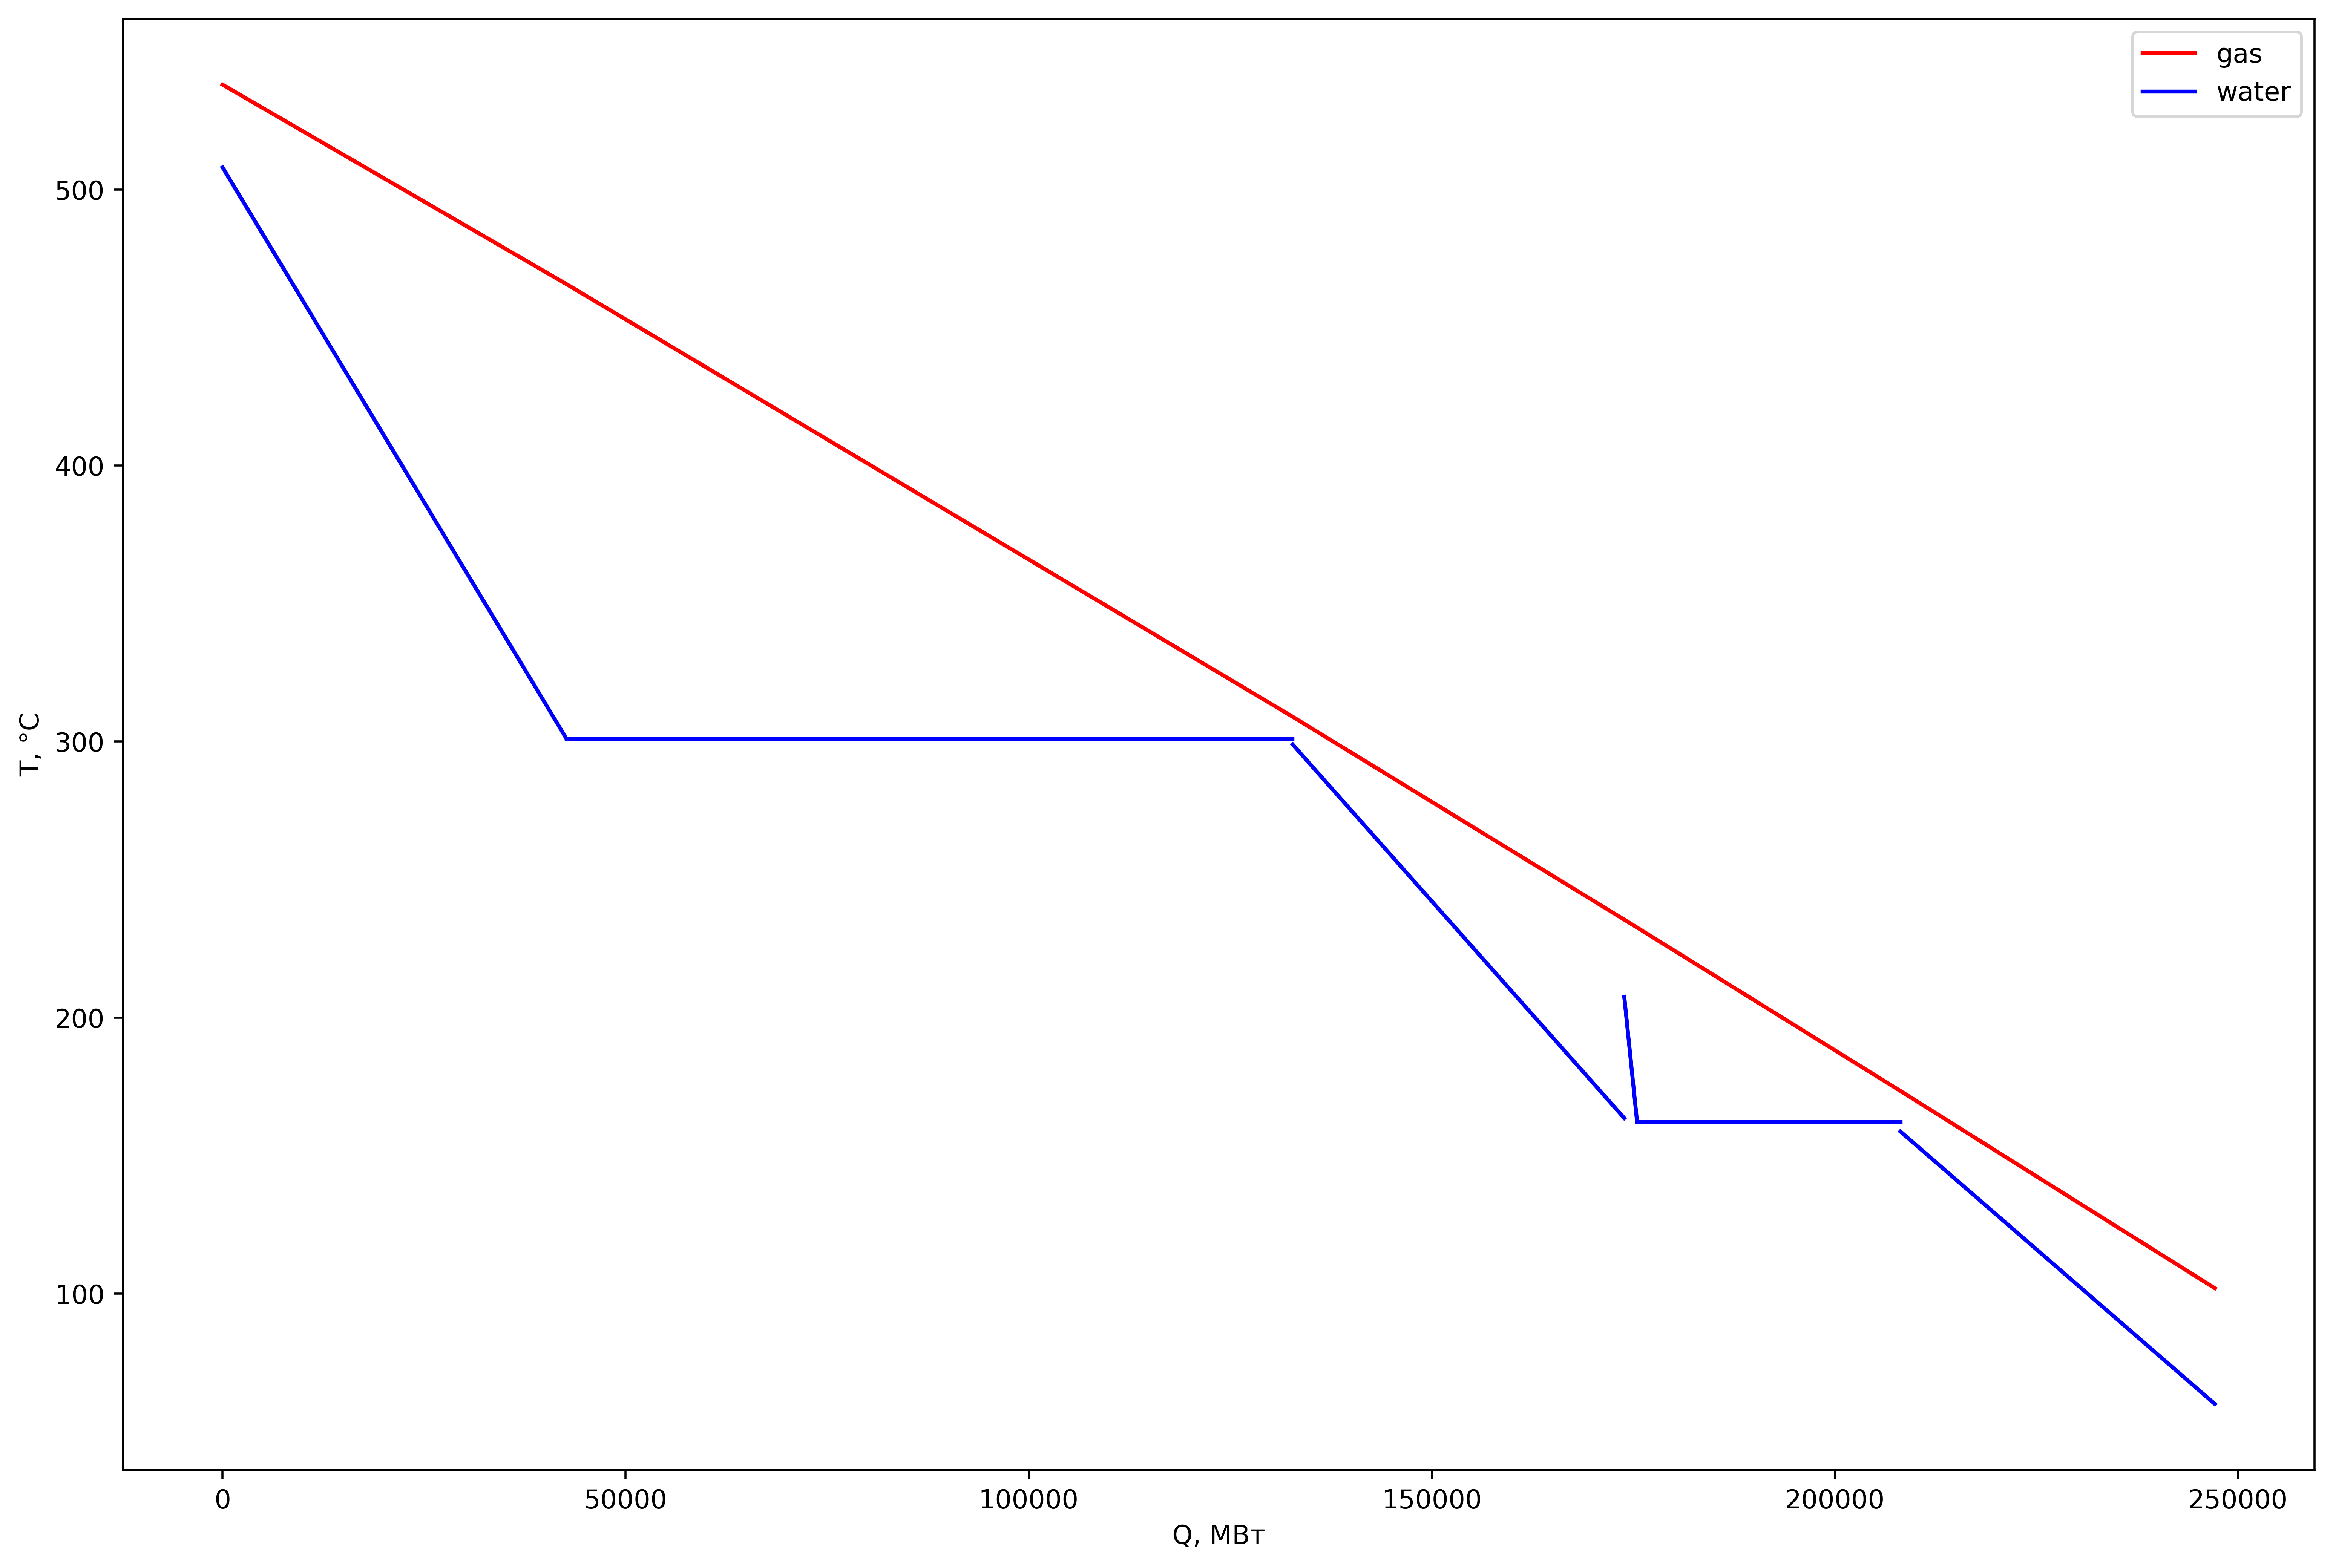

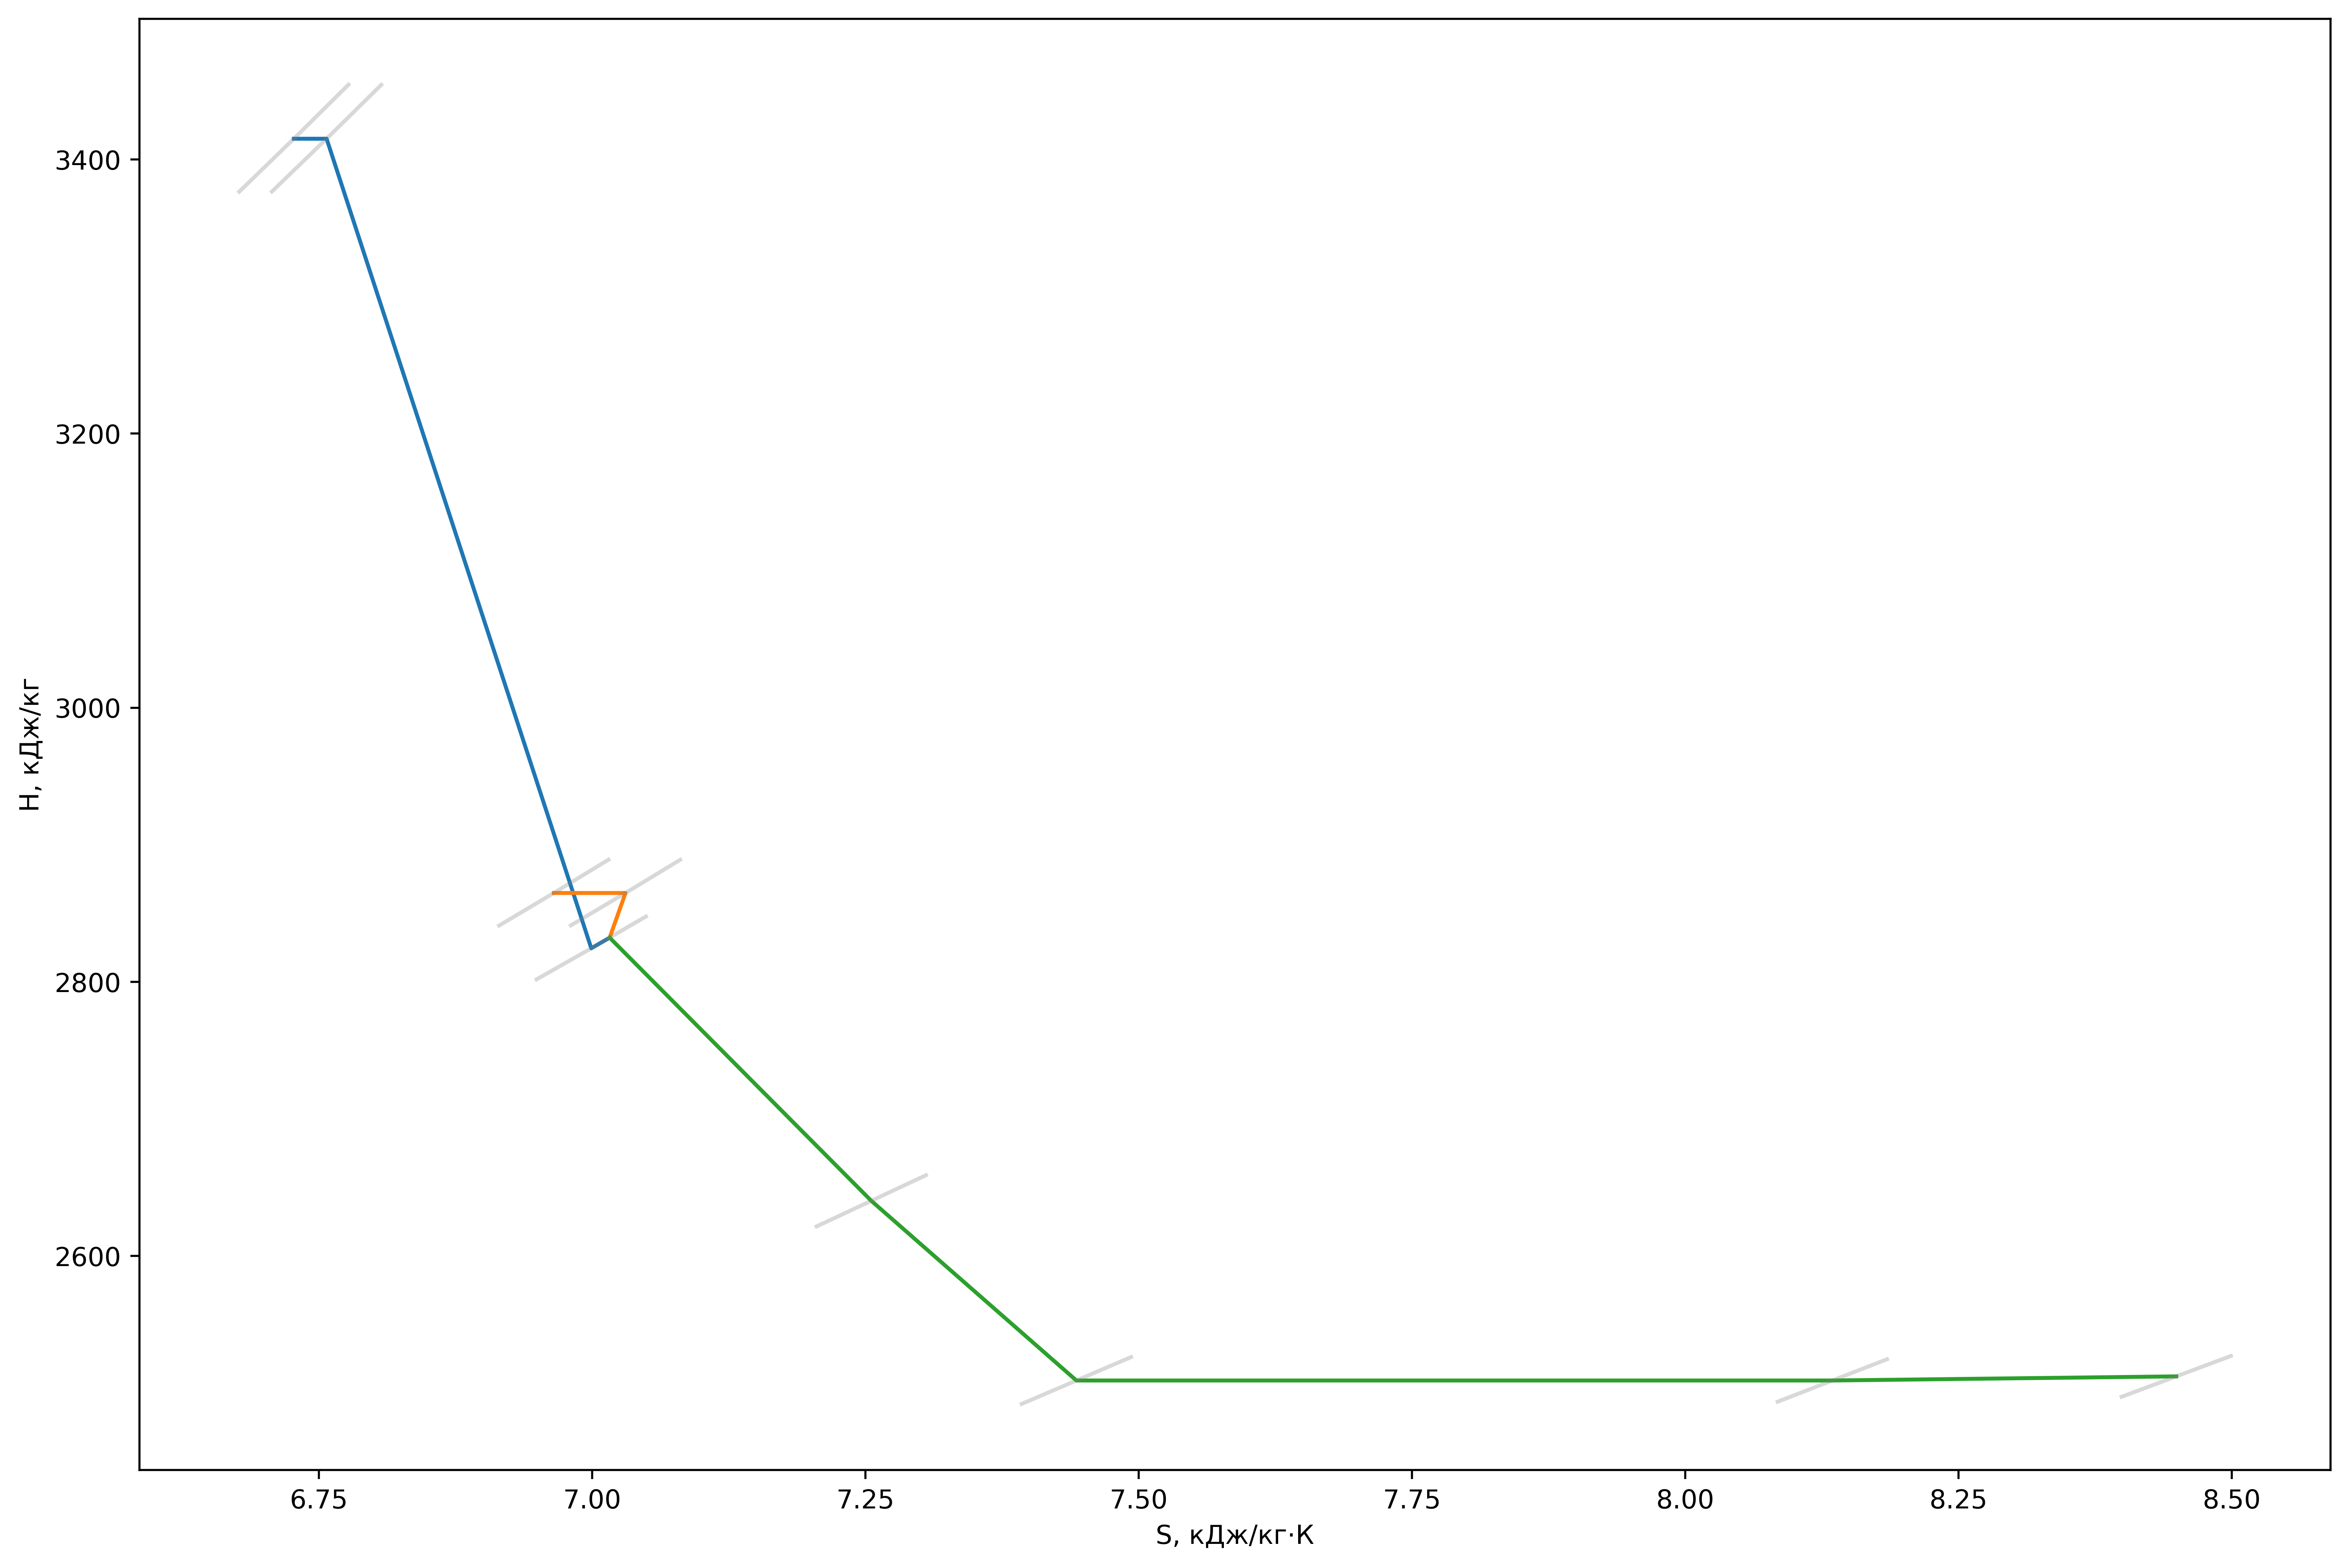

In [9]:
import Grafiki

Grafiki.Q_t_diagram(gas_streams, water_streams, heaters, 15, 10)
Grafiki.H_S_diagram(water, water_streams, 15, 10)
water_streams